In [1]:
pip install pvlib

Note: you may need to restart the kernel to use updated packages.


In [44]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.metrics import mean_squared_error

In [ ]:
#cec_modules = pvlib.pvsystem.retrieve_sam('cecmod')
#print(cec_modules.keys())

Index(['A10Green_Technology_A10J_S72_175', 'A10Green_Technology_A10J_S72_180',
       'A10Green_Technology_A10J_S72_185', 'A10Green_Technology_A10J_M60_220',
       'A10Green_Technology_A10J_M60_225', 'A10Green_Technology_A10J_M60_230',
       'A10Green_Technology_A10J_M60_235', 'A10Green_Technology_A10J_M60_240',
       'A2Peak_Power_POWER_ON_P220_6x10', 'Aavid_Solar_ASMS_165P',
       ...
       'Zytech_Solar_ZT275P', 'Zytech_Solar_ZT280P', 'Zytech_Solar_ZT285P',
       'Zytech_Solar_ZT290P', 'Zytech_Solar_ZT295P', 'Zytech_Solar_ZT300P',
       'Zytech_Solar_ZT305P', 'Zytech_Solar_ZT310P', 'Zytech_Solar_ZT315P',
       'Zytech_Solar_ZT320P'],
      dtype='object', length=21535)


In [5]:
# Retrieve all CEC module models
cec_modules = pvlib.pvsystem.retrieve_sam('cecmod')

# Filter for German manufacturers (e.g., Q CELLS, SolarWorld, Heckert)
german_modules = [name for name in cec_modules.keys() if any(brand in name for brand in ['Q_CELLS', 'SolarWorld', 'Heckert', 'Aleo', 'Axitec', 'Schott'])]

# Print available German PV modules
print(german_modules)

['Aleo_Solar_P18y250', 'Aleo_Solar_S18y250', 'Aleo_Solar_P18y255', 'Aleo_Solar_S18y255', 'Aleo_Solar_P18y260', 'Aleo_Solar_S18y260', 'Aleo_Solar_P18Y265', 'Aleo_Solar_S18y265', 'Aleo_Solar_S19Y270', 'Aleo_Solar_S79y270', 'Aleo_Solar_P19Y275', 'Aleo_Solar_S19y275', 'Aleo_Solar_S79y275', 'Aleo_Solar_S19y280', 'Aleo_Solar_S59y280', 'Aleo_Solar_S79y280', 'Aleo_Solar_P19Y285', 'Aleo_Solar_S19y285', 'Aleo_Solar_S59y285', 'Aleo_Solar_S79y285', 'Aleo_Solar_P19Y290', 'Aleo_Solar_S19y290', 'Aleo_Solar_S59y290', 'Aleo_Solar_S79Y290', 'Aleo_Solar_P19Y295', 'Aleo_Solar_S19Y295', 'Aleo_Solar_S59Y295', 'Aleo_Solar_S79Y295', 'Aleo_Solar_P19Y300', 'Aleo_Solar_S19Y300', 'Aleo_Solar_S59Y300', 'Aleo_Solar_S79Y300', 'Aleo_Solar_P19Y305', 'Aleo_Solar_S19Y305', 'Aleo_Solar_S59Y305', 'Aleo_Solar_S79Y305', 'Aleo_Solar_P19Y310', 'Aleo_Solar_S19Y310', 'Aleo_Solar_S59Y310', 'Hanwha_Q_CELLS_Q_PRO_G3_240', 'Hanwha_Q_CELLS_Q_PRO_BFR___G3_245', 'Hanwha_Q_CELLS_Q_PRO_G3_245', 'Hanwha_Q_CELLS_Q_PRO_BFR___G3_250', 'Hanw

In [ ]:
'''we use the a different inverter 

# Retrieve all CEC module models
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# Filter for German manufacturers (e.g., Q CELLS, SolarWorld, Heckert)
german_inverters = [name for name in cec_inverters.keys() if any(brand in name for brand in ['SMA'])]

# Print available German PV modules
print(german_inverters) '''

['SMA_America__SB_240_US_10__240V_', 'SMA_America__SB10000TL_US__208V_', 'SMA_America__SB10000TL_US__240V_', 'SMA_America__SB10000TL_US_12__208V_', 'SMA_America__SB10000TL_US_12__240V_', 'SMA_America__SB11000TL_US__240V_', 'SMA_America__SB11000TL_US_12__240V_', 'SMA_America__SB1100U__240V_', 'SMA_America__SB1100U_SBD__240V_', 'SMA_America__SB2000HFUS_30__208V_', 'SMA_America__SB2000HFUS_30__240V_', 'SMA_America__SB2500HFUS_30__208V_', 'SMA_America__SB2500HFUS_30__240V_', 'SMA_America__SB3_0_1SP_US_40__208V_', 'SMA_America__SB3_0_1SP_US_40__240V_', 'SMA_America__SB3_0_1TP_US_40__208V_', 'SMA_America__SB3_0_1TP_US_40__240V_', 'SMA_America__SB3_8_1SP_US_40__208V_', 'SMA_America__SB3_8_1SP_US_40__240V_', 'SMA_America__SB3_8_1TP_US_40__208V_', 'SMA_America__SB3_8_1TP_US_40__240V_', 'SMA_America__SB3000HFUS_30__208V_', 'SMA_America__SB3000HFUS_30__240V_', 'SMA_America__SB3000TL_US_22__208V_', 'SMA_America__SB3000TL_US_22__240V_', 'SMA_America__SB3000US__208V_', 'SMA_America__SB3000US__240V_'

### Calculating the inveter base on pannel connection and specifications.

In [39]:
# 
inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# Convert to DataFrame
df = pd.DataFrame(inverters).T  # Transpose for easier filtering

# Define filtering criteria
filtered_inverters = df[
    (df['Paco'] >= 9500) & (df['Paco'] <= 10500)&  # 10 kW capacity range

    (df['Idcmax'] >= 40) # Max DC current
]

print(filtered_inverters)

                                              Vac        Pso     Paco  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_  480  70.141754  10410.0   

                                                      Pdco   Vdco        C0  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_  10833.133789  270.0 -0.000002   

                                                    C1        C2       C3  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_ -0.000007 -0.000366  0.00007   

                                                Pnt Vdcmax     Idcmax  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_  3.123  380.0  40.122718   

                                             Mppt_low Mppt_high   CEC_Date  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_    225.0     380.0  2/15/2018   

                                                         CEC_Type  
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_  Utility Interactive  


In [64]:
latitude = 51.75
longitude = 10.61
weather= pvlib.iotools.get_pvgis_tmy(latitude, longitude)

# Print column names to check the correct naming
print(weather)

(                           temp_air  relative_humidity  ghi  dni  dhi   IR(h)  \
time(UTC)                                                                       
2006-01-01 00:00:00+00:00      4.72              92.39  0.0  0.0  0.0  329.89   
2006-01-01 01:00:00+00:00      3.89              93.41  0.0  0.0  0.0  326.56   
2006-01-01 02:00:00+00:00      3.05              94.43  0.0  0.0  0.0  323.24   
2006-01-01 03:00:00+00:00      2.22              95.45  0.0  0.0  0.0  319.91   
2006-01-01 04:00:00+00:00      1.39              96.47  0.0  0.0  0.0  316.58   
...                             ...                ...  ...  ...  ...     ...   
2021-12-31 19:00:00+00:00      8.89              87.29  0.0  0.0  0.0  346.53   
2021-12-31 20:00:00+00:00      8.06              88.31  0.0  0.0  0.0  343.20   
2021-12-31 21:00:00+00:00      7.22              89.33  0.0  0.0  0.0  339.88   
2021-12-31 22:00:00+00:00      6.39              90.35  0.0  0.0  0.0  336.55   
2021-12-31 23:00:00+00:00  

In [90]:
# Define location (latitude, longitude, altitude)
latitude = 51.75  # Example: New York
longitude = 10.61
altitude = 971  # meters
timezone = 'Etc/GMT+1'  # Time zone

# Create a location object
location = pvlib.location.Location(latitude, longitude, tz=timezone, altitude=altitude)

# Get weather data (use NSRDB, PVGIS, or TMY data)
weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]  # Get Typical Meteorological Year (TMY) data

# Convert to Local Time
weather.index = weather.index.tz_convert(timezone)

# Calculate solar position
solar_position = location.get_solarposition(weather.index)
module_params = pvlib.pvsystem.retrieve_sam('cecmod')['Aleo_Solar_P18y250']
inverter_params = pvlib.pvsystem.retrieve_sam('cecinverter')['Yaskawa_Solectria_Solar__PVI_10kW_480__480V_']
#print(module_params)
#print(inverter_params)

module_params['pdc0'] = 219.961  # W per module
module_params['gamma_pdc'] = -0.00476  # Temperature coefficient

inverter_params['pdc0'] = 10410  #  10W inverter
inverter_params['eta_inv_nom'] = 0.98  # Inverter efficency
#print(inverter_params)

# Define system parameters
system = {
    'surface_tilt': 32,  # Optimal tilt angle
    'surface_azimuth': 180,  # Facing south
    'module_parameters': module_params,  # Example module
    'inverter_parameters': inverter_params   # Example inverter
}

# Calculate plane of array (POA) irradiance
poa_irradiance = pvlib.irradiance.get_total_irradiance(
    system['surface_tilt'],
    system['surface_azimuth'],
    solar_position['apparent_zenith'],
    solar_position['azimuth'],
    ghi=weather['ghi'], # Global
    dni=weather['dni'], # Direct
    dhi=weather['dhi'], # Diffuse irradiance
    model='isotropic'
)

'''things to correct and check -----
# check the irradinace for horizontal plane. IMP
# losses of inverter and cables 
# check the pannel with number of string with inverter current. due to high current.
# Check the inverter type'''

modules_per_string = 10
strings_per_inverter = 4

#When using Sandia model we required Vdc 
""" DC voltage on each MPPT input of the inverter. Required when model=’sandia’  """

# Extract module reference voltage (Vmp)
V_mp_ref = module_params['V_mp_ref']  # Voltage at max power point [V]
#print(V_mp_ref)
# Estimate DC voltage per string (temperature corrected)
v_dc = V_mp_ref * modules_per_string  # DC voltage per string
#print(poa_irradiance['poa_global'])

# Calculate PV power output
temperature = weather['temp_air']  # Air temperature
pv_system = pvlib.pvsystem.PVSystem(module_parameters=system['module_parameters'], modules_per_string = modules_per_string, strings_per_inverter = 4,
                                    inverter_parameters=system['inverter_parameters'],surface_tilt=32, surface_azimuth=180,)
dc_output = pv_system.pvwatts_dc(g_poa_effective=poa_irradiance['poa_global'],  # POA irradiance in W/m²
    temp_cell=weather['temp_air']  # Cell temperature (or module temperature)
)

#print(dc_output)
ac_output = pv_system.get_ac(p_dc=dc_output, v_dc = v_dc,  model="sandia")



# Calculate daily and yearly energy generation
daily_energy = ac_output.resample('D').sum()  # kWh/day
yearly_energy = ac_output.resample('Y').sum().mean()  # kWh/year




Estimated Yearly PV Generation: 4110.79 kWh


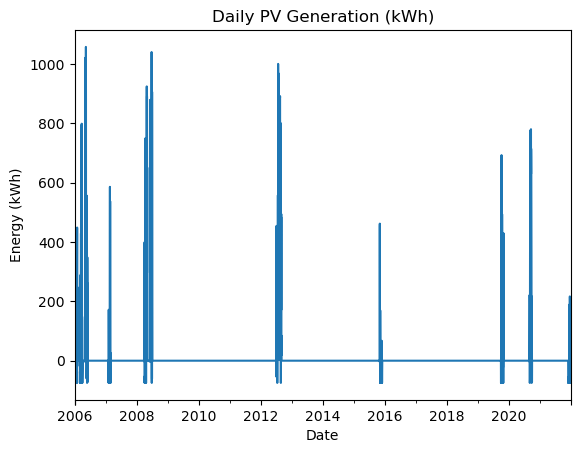

In [ ]:


# Results
print(f"Estimated Yearly PV Generation: {yearly_energy:.2f} kWh")


# Daily Energy Generation
daily_energy.plot(title="Daily PV Generation (kWh)", ylabel="Energy (kWh)", xlabel="Date")
plt.show()

In [42]:
yearly_energy

4110.787991058809

In [43]:
ac_output.resample('Y').sum()

time(UTC)
2005-12-31 00:00:00-01:00       -3.123000
2006-12-31 00:00:00-01:00    16799.193901
2007-12-31 00:00:00-01:00      301.692326
2008-12-31 00:00:00-01:00    19740.423853
2009-12-31 00:00:00-01:00        0.000000
2010-12-31 00:00:00-01:00        0.000000
2011-12-31 00:00:00-01:00        0.000000
2012-12-31 00:00:00-01:00    20709.359067
2013-12-31 00:00:00-01:00        0.000000
2014-12-31 00:00:00-01:00        0.000000
2015-12-31 00:00:00-01:00      452.241946
2016-12-31 00:00:00-01:00        0.000000
2017-12-31 00:00:00-01:00        0.000000
2018-12-31 00:00:00-01:00        0.000000
2019-12-31 00:00:00-01:00     2656.424340
2020-12-31 00:00:00-01:00    10371.180253
2021-12-31 00:00:00-01:00    -1143.996838
Freq: A-DEC, dtype: float64

### Due to the weather data we are getting very uneven result annualy.

# Getting the data openmeto data for better weather result. 

In [ ]:
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Important Defination.
# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def Hourly_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"hourly": variable,
	"models": ["era5_seamless"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_raw_data = hourly.Variables(0).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	hourly_data[variable] = hourly_raw_data

	hourly_dataframe = pd.DataFrame(data = hourly_data)

	if hourly_dataframe.empty:
		return print("The daily limit reached")
	return hourly_dataframe

In [148]:
#requesting API for all Irradiance
GHI_Global_Horizontal_Irradiance = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"shortwave_radiation")
DNI_Direct_Normal_Irradiance = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"direct_normal_irradiance")
DHI_Diffuse_Horizontal_Irradiance  = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"diffuse_radiation")


In [149]:
# getting temperture and wind data
temperature_2m = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"temperature_2m")
wind_speed_10m = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"wind_speed_10m")


In [150]:
# merge in on data frame
weather_new = GHI_Global_Horizontal_Irradiance.merge(DNI_Direct_Normal_Irradiance, on='date').merge(DHI_Diffuse_Horizontal_Irradiance, on='date').merge(temperature_2m, on='date').merge(wind_speed_10m , on='date')
weather_new.set_index('date', inplace=True) #set index as date/time
weather_new

,shortwave_radiation,direct_normal_irradiance,diffuse_radiation,temperature_2m,wind_speed_10m
date,,,,,
2013-12-31 23:00:00+00:00,0.0,0.0,0.0,-2.8555,10.895576
2014-01-01 00:00:00+00:00,0.0,0.0,0.0,-2.7055,10.661107
2014-01-01 01:00:00+00:00,0.0,0.0,0.0,-2.4055,10.853866
2014-01-01 02:00:00+00:00,0.0,0.0,0.0,-2.4055,10.105681
2014-01-01 03:00:00+00:00,0.0,0.0,0.0,-2.2555,10.182337
...,...,...,...,...,...
2024-12-31 18:00:00+00:00,0.0,0.0,0.0,-1.6055,18.047638
2024-12-31 19:00:00+00:00,0.0,0.0,0.0,-2.1555,19.406637
2024-12-31 20:00:00+00:00,0.0,0.0,0.0,-2.0055,21.010712


In [151]:
weather_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96432 entries, 2013-12-31 23:00:00+00:00 to 2024-12-31 22:00:00+00:00
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   shortwave_radiation       96432 non-null  float32
 1   direct_normal_irradiance  96432 non-null  float32
 2   diffuse_radiation         96432 non-null  float32
 3   temperature_2m            96432 non-null  float32
 4   wind_speed_10m            96432 non-null  float32
dtypes: float32(5)
memory usage: 2.6 MB


### Recalculating the PVlib senario with new weather data

In [152]:
print(weather_new[['shortwave_radiation', 'direct_normal_irradiance', 'diffuse_radiation']].describe())

       shortwave_radiation  direct_normal_irradiance  diffuse_radiation
count         96432.000000              96432.000000       96432.000000
mean            126.375610                139.090454          54.337429
std             195.878998                222.170364          75.061111
min               0.000000                  0.000000           0.000000
25%               0.000000                  0.000000           0.000000
50%               5.000000                  0.000000           5.000000
75%             194.000000                219.631695          98.000000
max             890.000000                920.224854         412.000000


In [153]:
#Recalculating the Output

# Define system parameters
# After correction
solar_position = location.get_solarposition(weather_new.index)

# Calculate plane of array (POA) irradiance
poa_irradiance = pvlib.irradiance.get_total_irradiance(
    system['surface_tilt'],
    system['surface_azimuth'],
    solar_position['apparent_zenith'],
    solar_position['azimuth'],
    ghi=weather_new["shortwave_radiation"],
    dni=weather_new["direct_normal_irradiance"],
    dhi=weather_new["diffuse_radiation"],
    model='isotropic'
)

# Extract module reference voltage (Vmp)
V_mp_ref = module_params['V_mp_ref']  # Voltage at max power point [V]

# Estimate DC voltage per string (temperature corrected)
v_dc = V_mp_ref * modules_per_string  # DC voltage per string

#previouly we were using atmospher Temp as module temp
# Compute module temperature using an appropriate model
temp_cell = pvlib.temperature.sapm_cell(
    poa_irradiance['poa_global'], weather_new["temperature_2m"], wind_speed=weather_new["wind_speed_10m"],
    **pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
)

# Calculate DC power with loss factor
dc_output = pv_system.pvwatts_dc(poa_irradiance['poa_global'], temp_cell)
dc_output_corrected = dc_output * 0.77  # Apply 23% losses for cables, soiling, mismatch,weather etc

# Apply inverter clipping & conversion efficiency
ac_output = pv_system.get_ac(p_dc=dc_output_corrected,v_dc=v_dc, model="sandia")

# Compute energy generation
daily_energy = ac_output.resample('D').sum()  
yearly_energy = ac_output.resample('Y').sum().mean()  

# Print corrected results
print(f"Estimated Yearly PV Generation: {yearly_energy:.2f} kWh")



Estimated Yearly PV Generation: 21317.91 kWh


In [154]:
print(weather.index.shape, ac_output.index.shape)

(8760,) (96432,)


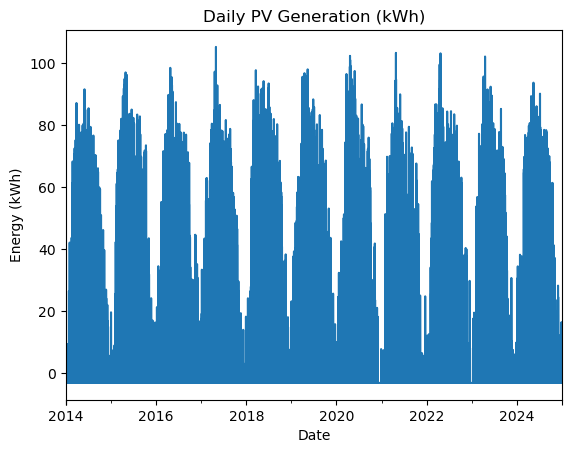

In [155]:

ac_output.plot(title="Daily PV Generation (kWh)", ylabel="Energy (kWh)", xlabel="Date")
plt.show()

glass/glass - open rack


open rack” refers to mounting that allows relatively free air flow. This case is typical of ground-mounted systems on fixed racking or single axis trackers.

“close mount” refers to limited or restricted air flow. This case is typical of roof-mounted systems with some gap behind the module.

“insulated back” refers to systems with no air flow contacting the rear surface of the module. This case is typical of building-integrated PV systems, or systems laid flat on a ground surface.

In [156]:
energy_year_kwp = yearly_energy/10 # 10 installed capacity 
energy_year_kwp

2131.790786320408

In [157]:
temp_cell.info()


<class 'pandas.core.series.Series'>
DatetimeIndex: 96432 entries, 2013-12-31 23:00:00+00:00 to 2024-12-31 22:00:00+00:00
Series name: None
Non-Null Count  Dtype  
--------------  -----  
96432 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [159]:
winter_energy = ac_output[weather.index.month.isin([10, 11, 12, 1, 2, 3])].resample('D').sum().mean()
summer_energy = ac_output[weather.index.month.isin([5, 4, 6, 7, 8, 9])].resample('D').sum().mean()

# Plot Daily Energy Generation
ac_output.plot(title="Daily PV Generation (kWh)", ylabel="Energy (kWh)", xlabel="Date")
plt.show()

IndexError: Boolean index has wrong length: 8760 instead of 96432

In [147]:
winter_energy

-11.020257961084592

In [144]:
ac_output.resample('Y').sum()

date
2004-12-31 00:00:00+00:00       -3.123000
2005-12-31 00:00:00+00:00    21913.437554
2006-12-31 00:00:00+00:00    22576.831322
2007-12-31 00:00:00+00:00    21112.241735
2008-12-31 00:00:00+00:00    17664.689783
2009-12-31 00:00:00+00:00    18601.618306
2010-12-31 00:00:00+00:00    18605.979042
2011-12-31 00:00:00+00:00    28326.863480
2012-12-31 00:00:00+00:00    19209.682165
2013-12-31 00:00:00+00:00    15248.116513
2014-12-31 00:00:00+00:00    18133.845763
2015-12-31 00:00:00+00:00    23043.138532
2016-12-31 00:00:00+00:00    21514.851087
2017-12-31 00:00:00+00:00    16131.514425
2018-12-31 00:00:00+00:00    33405.899882
2019-12-31 00:00:00+00:00    27378.665596
2020-12-31 00:00:00+00:00    26538.878041
2021-12-31 00:00:00+00:00    15802.903367
2022-12-31 00:00:00+00:00    27788.668125
2023-12-31 00:00:00+00:00    22855.962594
2024-12-31 00:00:00+00:00    23223.689946
Freq: A-DEC, dtype: float64

In [106]:
non_negative_ac = ac_output[ac_output < 0] = 0
non_negative_ac


0

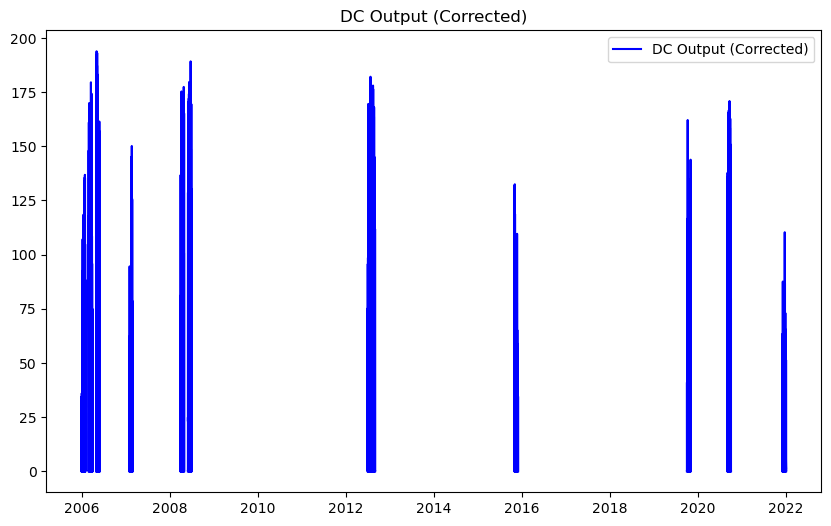

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(dc_output_corrected, label='DC Output (Corrected)', color='blue')
plt.title('DC Output (Corrected)')
plt.legend()
plt.show()

In [80]:
dc_output_corrected.resample('Y').sum()

2004-12-31 00:00:00+00:00        0.000000
2005-12-31 00:00:00+00:00        0.000000
2006-12-31 00:00:00+00:00    68265.897795
2007-12-31 00:00:00+00:00    10476.188898
2008-12-31 00:00:00+00:00    58117.026598
2009-12-31 00:00:00+00:00        0.000000
2010-12-31 00:00:00+00:00        0.000000
2011-12-31 00:00:00+00:00        0.000000
2012-12-31 00:00:00+00:00    61608.986168
2013-12-31 00:00:00+00:00        0.000000
2014-12-31 00:00:00+00:00        0.000000
2015-12-31 00:00:00+00:00    10042.648962
2016-12-31 00:00:00+00:00        0.000000
2017-12-31 00:00:00+00:00        0.000000
2018-12-31 00:00:00+00:00        0.000000
2019-12-31 00:00:00+00:00    16691.744165
2020-12-31 00:00:00+00:00    25501.435968
2021-12-31 00:00:00+00:00     4988.793393
2022-12-31 00:00:00+00:00        0.000000
2023-12-31 00:00:00+00:00        0.000000
2024-12-31 00:00:00+00:00        0.000000
Freq: A-DEC, dtype: float64

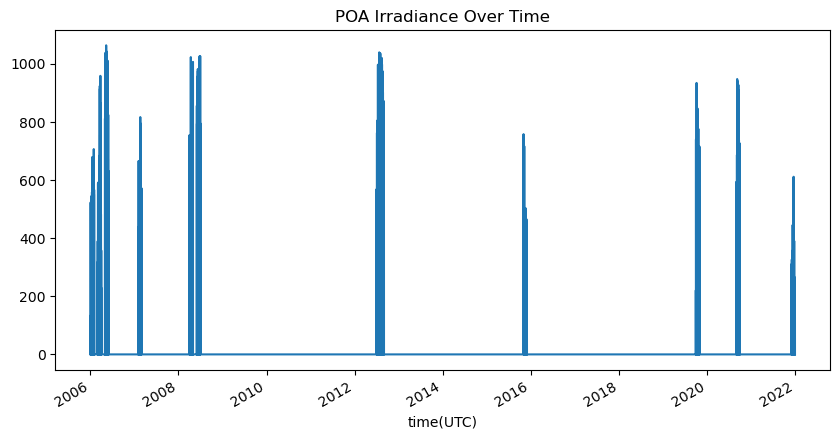

In [93]:
plt.figure(figsize=(10, 5))
poa_irradiance['poa_global'].plot(title="POA Irradiance Over Time")
plt.show()

In [95]:
poa_irradiance.describe()

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,132.437738,68.909596,63.528142,61.276507,2.251635
std,224.010540,165.230799,93.601064,90.585711,3.683330
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,171.629283,19.934775,107.235587,102.566669,3.153002
max,1062.606383,944.964119,419.473130,408.418629,17.417487


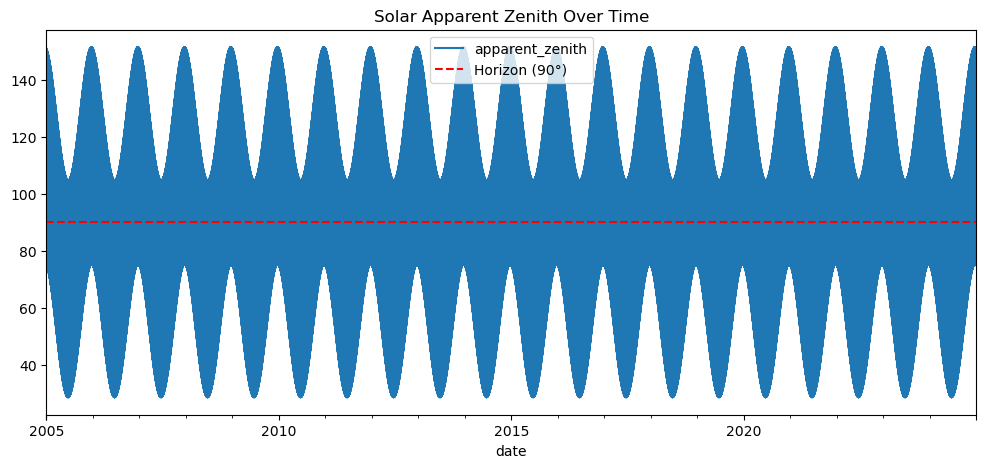

In [117]:
plt.figure(figsize=(12, 5))
solar_position['apparent_zenith'].plot(title="Solar Apparent Zenith Over Time")
plt.axhline(90, color='red', linestyle='--', label="Horizon (90°)")
plt.legend()
plt.show()

In [97]:
print(solar_position.isnull().sum())


apparent_zenith       0
zenith                0
apparent_elevation    0
elevation             0
azimuth               0
equation_of_time      0
dtype: int64


In [118]:
print(weather_new.index.min(), weather_new.index.max())
print(solar_position.index.min(), solar_position.index.max())

2004-12-31 23:00:00+00:00 2024-12-31 22:00:00+00:00
2004-12-31 23:00:00+00:00 2024-12-31 22:00:00+00:00
